In [1]:
import warnings
import os
from IPython.display import Audio, display
import numpy as np
#import librosa
#from librosa.display import specshow
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, dct, ifft
from sklearn.model_selection import train_test_split
from scipy.stats import norm
warnings.simplefilter('error')
%matplotlib inline

In [21]:
DATA_PATH = os.path.join('data', 'genres')

files = []
for root, directories, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        files.append(os.path.join(DATA_PATH, os.path.basename(root), filename))

In [29]:
SAMPLE_RATE = 22050
waves = {}
for i, file in enumerate(files):
    print("Progress : %d / %d" % (i + 1, len(files)), end='\r')
    try:
        waves[file] = librosa.load(file, sr=SAMPLE_RATE)[0]
    except:
        continue

In [38]:
lens = set()
for v in waves.values():
    lens.add(len(v))
len(lens)

32

In [39]:
max(lens) - min(lens)

15808

In [41]:
COMMON_LEN = min(lens) 
for f, wave in waves.items():
    waves[f] = wave[:COMMON_LEN]

In [53]:
COMMON_LEN

660000

In [42]:
## check lens
for wave in waves.values():
    if len(wave) != COMMON_LEN:
        print("FAILED!!!")
        break
else:
    print("SUCCESS")

SUCCESS


In [43]:
len(waves)

850

In [54]:
MFCC_COEFS = 12
MEL_COEFS = 128
def mfcc_extractor(sound):
    train_mfcc = librosa.feature.mfcc(sound, sr=SAMPLE_RATE, n_mfcc=MFCC_COEFS, 
                                      n_mels=MEL_COEFS, n_fft=441, hop_length=330)
    grad = librosa.feature.delta(train_mfcc)
    gess = librosa.feature.delta(train_mfcc, order=2)
    en = np.sum(train_mfcc ** 2, axis=0)
    en1 = np.sum(grad ** 2, axis=0)
    en2 = np.sum(gess ** 2, axis=0)
    return np.vstack([train_mfcc, grad, gess,
                            en.reshape(1, -1), en1.reshape(1, -1), en2.reshape(1, -1)])

In [55]:
mfccs = {}
for i, (f, wave) in enumerate(waves.items()):
    print("Progress: %d / %d" % (i + 1, len(waves)), end='\r')
    try:
        mfccs[f] = mfcc_extractor(wave)
    except:
        continue
len(mfccs)

850

In [58]:
MFCC_SHAPE = (39, 2000)
for mfcc in mfccs.values():
    if mfcc.shape != MFCC_SHAPE:
        print("FAILED")
else:
    print("SUCCESS")

SUCCESS


In [60]:
cls = os.listdir(DATA_PATH)
cls

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae']

In [65]:
DST_PATH = 'data/mfccs_genres'
os.mkdir(DST_PATH)
for cl in cls:
    os.mkdir(os.path.join(DST_PATH, cl))

In [67]:
for i, (f, mfcc) in enumerate(mfccs.items()):
    print("Progess: %d / %d" % (i + 1, len(mfccs)), end='\r')
    np.save(os.path.join(DST_PATH, '/'.join(f.split('\\')[-2:])), mfcc)

In [71]:
filenames = pd.Series(list(mfccs.keys()))
filenames.sample(5)

798                data\genres\pop\pop.00098.au
794                data\genres\pop\pop.00094.au
165    data\genres\classical\classical.00065.au
47             data\genres\blues\blues.00047.au
677            data\genres\metal\metal.00077.au
dtype: object

In [84]:
column_names = ['filename'] + ['mfcc_' + str(i) for i  in range(1, 40)]
df_mfccs = pd.DataFrame(columns=column_names)
for i, (filename, mfcc) in enumerate(mfccs.items()):
    print("Progess: %d / %d" % (i + 1, len(mfccs)), end='\r')
    df_sample = pd.DataFrame(mfcc.T, columns=['mfcc_' + str(i) for i  in range(1, 40)])
    df_sample['filename'] = filename
    df_mfccs = pd.concat([df_mfccs, df_sample], 
                             axis=0, ignore_index=True)
df_mfccs.sample(5)

,filename,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,...,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9
1418329,data\genres\pop\pop.00009.au,-271.189181,-0.379043,8.008707,-8.054323,-7.168379,3.703635,-5.492611,-3.942107,1.134062,...,-0.564668,79179.915363,127.662035,31.468316,-21.434582,-2.848380,5.997716,-18.757499,20.561686,4.483444
1061223,data\genres\jazz\jazz.00030.au,-542.207928,20.499251,-8.342168,1.861900,-1.914170,-1.313589,1.029697,-1.247165,-1.571554,...,-0.950463,318940.309762,21.570324,5.471837,16.452175,-10.480318,18.673560,-9.405268,-3.375156,-22.099695
1295250,data\genres\metal\metal.00047.au,-201.204420,21.768659,10.405167,31.280040,1.622149,3.077620,-3.241089,-0.759668,-0.614036,...,0.681049,57988.668460,29.946525,16.478193,78.474725,-3.728022,28.761698,-12.877247,-0.473153,-10.791979
1355613,data\genres\metal\metal.00077.au,-207.674588,18.604337,-14.660628,17.145147,1.279467,-0.645939,1.441405,0.301823,-2.634933,...,-0.364862,57600.382034,17.004997,15.558519,44.200526,-28.251629,6.677746,-30.930551,8.114981,-20.787358
119814,data\genres\blues\blues.00059.au,-399.492632,21.188324,12.365740,7.994017,-11.338418,-1.316701,-1.265892,-0.950001,1.162593,...,1.350656,176868.719368,147.350848,49.529383,59.769475,19.433933,37.100472,12.477972,9.756050,20.843985


In [85]:
df_mfccs['class'] = df_mfccs['filename'].apply(lambda x: x.split('\\')[-2])
df_mfccs.sample(5)

,filename,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,...,mfcc_37,mfcc_38,mfcc_39,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,class
196504,data\genres\blues\blues.00098.au,-192.841456,12.124535,-25.097583,27.262943,-6.851198,1.451829,0.875735,-0.667574,0.608799,...,54001.810367,55.486586,20.843629,60.108168,-6.543520,23.807326,-11.902412,-2.554969,-32.897878,blues
1261500,data\genres\metal\metal.00030.au,-154.422847,20.342139,-16.109003,15.993555,1.032489,-4.870743,4.066390,1.583203,1.867023,...,37557.469286,66.013918,60.715145,73.160153,-4.699153,32.165636,-23.975719,23.140785,-24.637278,metal
787296,data\genres\disco\disco.00093.au,-299.306307,3.310125,-17.039769,14.567200,0.118093,-1.461747,-7.588529,1.220297,-4.222218,...,115415.256871,109.766935,96.264712,26.476763,27.715701,31.235344,7.995160,23.257126,-17.954645,disco
339367,data\genres\classical\classical.00069.au,-469.883574,-4.054606,-16.805579,-6.627156,-1.716796,-2.328888,-1.321688,-1.257109,-1.022276,...,248728.430518,18.121920,7.213837,31.407006,-2.294549,13.558393,5.603602,-14.033630,-10.007686,classical
1065739,data\genres\jazz\jazz.00032.au,-492.342810,-15.635557,-8.963865,-13.423555,-2.721421,0.891949,-0.399311,-0.305061,1.388270,...,272821.971821,13.067898,2.898811,4.315637,-10.337390,-0.051408,0.195425,-5.954586,-5.087456,jazz


In [88]:
class2lbl = {
    'blues'     : 1, 
    'classical' : 2, 
    'country'   : 3, 
    'disco'     : 4, 
    'hiphop'    : 5, 
    'jazz'      : 6,
    'metal'     : 7, 
    'pop'       : 8, 
    'reggae'    : 9
}

In [89]:
df_mfccs['lbl'] = df_mfccs['class'].apply(lambda x: class2lbl[x])
df_mfccs.sample(5)

,filename,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,...,mfcc_38,mfcc_39,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,class,lbl
875961,data\genres\hiphop\hiphop.00037.au,-220.186969,-9.104437,-11.664980,7.223728,-10.706158,4.101812,-1.726852,0.292851,-3.098804,...,159.015602,41.560072,7.196409,22.125761,28.002191,29.645184,7.326017,1.944602,hiphop,5
696696,data\genres\disco\disco.00048.au,-235.354891,-0.932937,-0.445863,14.472037,-16.575084,2.991631,-0.334694,2.600918,8.063916,...,366.360428,51.188067,28.130913,-11.868188,13.103963,-11.052224,40.602680,-28.864856,disco,4
1053079,data\genres\jazz\jazz.00026.au,-498.248982,-22.149600,-27.231262,30.311747,-1.985979,0.584895,-2.160114,-0.220295,-0.473938,...,18.563731,2.534040,14.293643,-23.666431,11.311255,-19.947893,16.009445,-26.100700,jazz,6
209665,data\genres\classical\classical.00004.au,-432.472478,15.542665,22.852316,0.399358,-0.878167,-0.073409,-2.569664,-1.536056,0.059070,...,14.570813,8.056810,26.709357,-17.350918,8.830866,-18.319617,-16.768158,-14.133540,classical,2
131341,data\genres\blues\blues.00065.au,-342.037980,1.466371,-18.669905,8.739418,15.301640,-0.275280,-0.135732,0.811787,-0.631983,...,251.130184,8.495772,58.241259,-13.215091,15.956245,-35.590336,2.923225,-3.575607,blues,1


In [90]:
df_mfccs = df_mfccs[['filename', 'class', 'lbl'] + ['mfcc_' + str(i) for i  in range(1, 40)]]
df_mfccs.sample(5)

,filename,class,lbl,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_30,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39
372818,data\genres\classical\classical.00086.au,classical,2,-377.925326,134.336490,-49.277252,34.060878,-8.359388,21.762307,-12.880090,...,-1.326005,-0.681095,-0.097649,-0.356818,-0.226590,-1.080616,-2.496041,165716.709103,71.666418,40.020343
1064949,data\genres\jazz\jazz.00032.au,jazz,6,-542.163610,139.373011,56.332340,58.735100,19.208206,27.748243,15.555254,...,-0.158190,-0.551533,0.957138,1.095632,0.768322,-0.345945,1.209800,321869.475539,74.826719,13.270930
1571114,data\genres\pop\pop.00085.au,pop,8,-276.772795,62.504740,110.811791,46.025701,7.080954,6.262214,27.558208,...,2.123204,1.439932,2.226911,1.229315,0.646859,-0.900076,1.556502,96015.083317,1074.066768,162.653701
1494112,data\genres\pop\pop.00047.au,pop,8,-152.954677,84.653199,-13.206705,9.014038,12.071753,-1.496008,-7.307381,...,2.098420,2.641092,0.985074,-1.981202,0.938230,-0.166463,-1.581187,31680.984946,189.939261,37.000644
1121768,data\genres\jazz\jazz.00060.au,jazz,6,-289.280932,156.350564,-35.520444,25.688923,7.764480,-1.139185,5.285017,...,-1.638169,0.411222,1.033027,0.565260,0.000887,-1.060355,0.117661,110499.044178,48.324504,9.616942


In [91]:
df_mfccs['filename'] = df_mfccs['filename'].apply(lambda x: '/'.join(x.split('\\')[-2:]))
df_mfccs.sample(5)

,filename,class,lbl,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_30,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39
1659617,reggae/reggae.00029.au,reggae,9,-435.887900,123.746502,34.983399,73.091238,22.779460,35.688400,8.636426,...,-1.158190,-1.240506,0.204060,-0.279990,0.220542,-0.097006,1.652157,214220.325044,142.941691,18.131916
756889,disco/disco.00078.au,disco,4,-296.781491,116.035046,-31.250023,43.826157,1.291585,20.243145,-19.784648,...,-0.718835,-0.020683,0.484139,-1.615856,-2.070866,-1.247894,2.047377,106105.419296,24.719017,35.882177
134312,blues/blues.00067.au,blues,1,-304.294093,112.735872,23.432327,59.068242,-6.692657,14.761574,-50.057827,...,0.483008,2.576887,3.086557,1.163243,0.482537,1.075495,0.010147,113214.235550,182.225249,36.665848
478486,country/country.00039.au,country,3,-213.851432,28.392015,-13.449608,41.266499,2.938652,-0.767169,-9.017589,...,0.627268,2.055635,0.435013,0.968737,0.984868,-0.079750,-1.352681,48970.637563,63.919950,219.504526
102557,blues/blues.00051.au,blues,1,-248.292758,109.418492,-38.139631,58.712113,-11.151660,9.705630,-8.926905,...,0.041440,0.117283,-1.420314,-1.411053,2.523004,-0.057746,-0.263479,80142.006753,61.106225,53.514415


In [93]:
df_mfccs.to_csv('data/list_mfccs.csv', index=None)

In [95]:
mfccs_columns = ['mfcc_' + str(i) for i  in range(1, 40)]
means = np.array(df_mfccs[mfccs_columns].mean())

In [98]:
means

array([-3.06361016e+02,  1.05540514e+02, -6.81725492e+00,  3.52314962e+01,
       -8.43053763e-02,  1.31217474e+01, -6.32619909e+00,  5.97222811e+00,
       -1.00541418e+01,  5.30146802e+00, -5.15876793e+00,  5.44507806e+00,
        9.91734609e-03,  9.42358188e-04, -1.37527333e-03,  8.39388125e-04,
       -9.11329246e-04,  9.99707518e-04, -1.14366317e-03,  7.51635081e-04,
       -7.99993116e-04,  2.35506141e-04, -8.05091586e-04,  8.39820745e-04,
        1.74729401e-04, -1.81443088e-03,  5.89198023e-04, -1.07557727e-03,
        1.10021589e-03, -7.69683687e-04,  4.08600170e-04, -6.53653393e-04,
        6.47737162e-04, -2.97134126e-04,  5.81508539e-04, -4.07872409e-04,
        1.26295894e+05,  1.53637724e+02,  5.40922254e+01])

In [99]:
stds = np.array(df_mfccs[mfccs_columns].std())

In [100]:
stds

array([1.17794075e+02, 4.58205444e+01, 3.27203664e+01, 2.42906558e+01,
       1.95046469e+01, 1.82702450e+01, 1.61740334e+01, 1.58938929e+01,
       1.40754715e+01, 1.38487694e+01, 1.28603466e+01, 1.26333680e+01,
       9.53890114e+00, 4.42034417e+00, 3.42645780e+00, 2.40398565e+00,
       2.16695893e+00, 2.03597016e+00, 1.88330381e+00, 1.73351570e+00,
       1.67010315e+00, 1.63017694e+00, 1.57259164e+00, 1.50841239e+00,
       5.57176709e+00, 2.56347335e+00, 1.97252192e+00, 1.44516033e+00,
       1.32396112e+00, 1.27019282e+00, 1.19287951e+00, 1.13268097e+00,
       1.08903688e+00, 1.06914656e+00, 1.04211379e+00, 1.00482159e+00,
       9.05459197e+04, 2.44846297e+02, 9.10885257e+01])

In [11]:
df_train = pd.read_csv('data/train_list_mfccs.csv')
df_val = pd.read_csv('data/val_list_mfccs.csv')
df_test = pd.read_csv('data/test_list_mfccs.csv')
df_mfccs = pd.concat([df_train, df_val, df_test], ignore_index=True, axis=0)
df_mfccs.sample(5)

,filename,class,lbl,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_30,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39
937852,jazz/jazz.00065.au,jazz,6,-398.621007,177.293978,-15.148369,56.442158,-18.556127,-44.334826,-20.988875,...,0.968977,0.295512,0.994145,-0.039168,-1.076313,-1.187842,-0.742152,197802.519999,340.500785,11.778423
1448908,hiphop/hiphop.00095.au,hiphop,5,-240.332531,76.906271,-29.969458,62.604175,-12.317517,43.579363,1.527574,...,0.735719,1.327964,2.793879,0.371013,-0.259995,0.444440,-0.626458,72309.450713,94.818273,23.743901
1306416,reggae/reggae.00038.au,reggae,9,-367.621665,65.192143,39.150724,26.526621,-5.983109,28.771621,-8.529037,...,0.558781,3.780766,-0.158262,3.268339,-1.750372,2.256529,-0.153184,144545.605937,65.789921,196.834981
229957,classical/classical.00012.au,classical,2,-554.465584,98.663454,-22.473721,58.165200,-3.140247,16.050741,-14.245091,...,-1.879742,-1.327465,-2.089860,-2.401308,-0.843446,-0.582789,0.032692,322919.477973,31.095792,18.472335
700502,hiphop/hiphop.00091.au,hiphop,5,-331.369227,109.568349,-7.733107,65.501792,19.655549,30.256608,-5.709267,...,0.957952,1.407985,0.749087,-0.014844,1.062344,0.278660,0.416188,128398.081742,107.717660,18.288788


In [12]:
from random import shuffle
def train_val_split(df, cls):
    df_cls = df[df['lbl'] == cls]
    files_cls = df_cls['filename'].unique()
    shuffle(files_cls)
    #df_cls.sample(frac=1.0, random_state=777).reset_index(drop=True)
    
    size_df = files_cls.shape[0]
    files_train = files_cls[ : int(0.8 * size_df)]
    files_val = files_cls[int(0.8 * size_df) : int(0.9 * size_df)]
    files_test = files_cls[int(0.9 * size_df) : ]
    df_train = df_cls[df_cls['filename'].isin(files_train)]
    df_val = df_cls[df_cls['filename'].isin(files_val)]
    df_test = df_cls[df_cls['filename'].isin(files_test)]
    return df_train, df_val, df_test

In [13]:
mfccs_columns = ['mfcc_' + str(i) for i  in range(1, 40)]

df_train = pd.DataFrame(columns=['filename', 'class', 'lbl'] + mfccs_columns)
df_val = pd.DataFrame(columns=['filename', 'class', 'lbl'] + mfccs_columns)
df_test = pd.DataFrame(columns=['filename', 'class', 'lbl'] + mfccs_columns)

for i in [2, 6, 7]:
    df_train_cls, df_val_cls, df_test_cls = train_val_split(df_mfccs, i)
    df_train = pd.concat([df_train, df_train_cls], axis=0, ignore_index=True)
    df_val = pd.concat([df_val, df_val_cls], axis=0, ignore_index=True)
    df_test = pd.concat([df_test, df_test_cls], axis=0, ignore_index=True)
df_train.shape, df_val.shape, df_test.shape

((480000, 42), (60000, 42), (60000, 42))

In [14]:
set(df_train['filename'].unique()).intersection(set(df_val['filename'].unique())), \
set(df_val['filename'].unique()).intersection(set(df_test['filename'].unique())), \
set(df_test['filename'].unique()).intersection(set(df_train['filename'].unique()))

(set(), set(), set())

In [15]:
df_val['class'].value_counts()

metal        20000
jazz         20000
classical    20000
Name: class, dtype: int64

In [16]:
df_mfccs['class'].value_counts()

country      200000
metal        200000
blues        200000
pop          200000
classical    200000
disco        200000
jazz         200000
hiphop       200000
reggae       100000
Name: class, dtype: int64

In [20]:
df_train.loc[df_train['lbl'] == 2, 'lbl'] -= 1
df_train.loc[df_train['lbl'] == 6, 'lbl'] -= 4
df_train.loc[df_train['lbl'] == 7, 'lbl'] -= 4

df_val.loc[df_val['lbl'] == 2, 'lbl'] -= 1
df_val.loc[df_val['lbl'] == 6, 'lbl'] -= 4
df_val.loc[df_val['lbl'] == 7, 'lbl'] -= 4

df_test.loc[df_test['lbl'] == 2, 'lbl'] -= 1
df_test.loc[df_test['lbl'] == 6, 'lbl'] -= 4
df_test.loc[df_test['lbl'] == 7, 'lbl'] -= 4

df_train['lbl'].unique(), df_val['lbl'].unique(), df_test['lbl'].unique()

(array([1, 2, 3], dtype=object),
 array([1, 2, 3], dtype=object),
 array([1, 2, 3], dtype=object))

In [21]:
df_train.to_csv('data/train_list_mfccs_3_cls.csv', index=None)
df_val.to_csv('data/val_list_mfccs_3_cls.csv', index=None)
df_test.to_csv('data/test_list_mfccs_3_cls.csv', index=None)

In [12]:
pd.Series(df_train['filename'].unique()).to_csv('data/train_files.csv')
pd.Series(df_val['filename'].unique()).to_csv('data/val_files.csv')
pd.Series(df_test['filename'].unique()).to_csv('data/test_files.csv')

In [22]:
info_val = pd.read_csv('models/DNN_39_128_9/results.csv')
info_val.sample(5)

,true_lbl,1_scr,2_scr,3_scr,1_lbl,2_lbl,3_lbl
11161,2,0.350787,0.331875,0.317338,3,1,2
365,3,0.350787,0.331875,0.317338,3,1,2
36499,2,0.350787,0.331875,0.317338,3,1,2
56866,1,0.350787,0.331875,0.317338,3,1,2
1186,3,0.350787,0.331875,0.317338,3,1,2


In [23]:
info_val['1_lbl'].unique()

array([3])

In [25]:
np.abs(df_mfccs['mfcc_1']).min()

0.06095225513570759

## графики подъехали

In [30]:
df_inf_train = pd.read_csv('models/DNN_39_128_9/inform_DNN_adam_train.log')
df_inf_val = pd.read_csv('models/DNN_39_128_9/inform_DNN_adam_val.log')
df_inf_train.sample(5)

,epoch,num_batch,loss,accuracy,agg_loss,agg_acc,lr,time_on_batch
91680,49.0,1681.0,1.085982,55.859375,1.085174,55.121579,0.000008,0.001750
19552,11.0,803.0,1.090171,41.015625,1.090983,39.631168,0.000008,0.006661
5754,4.0,130.0,1.094059,38.281250,1.092012,37.052284,0.000008,0.027845
33254,18.0,1380.0,1.089727,40.234375,1.089887,42.476789,0.000008,0.004672
74311,40.0,1187.0,1.086821,54.296875,1.086583,52.134780,0.000008,0.001492


In [31]:
df_grp_epoch_train = df_inf_train.groupby('epoch').last()
df_grp_epoch_val = df_inf_val.groupby('epoch').last()

df_grp_epoch_train.shape, df_grp_epoch_val.shape

((50, 7), (50, 7))

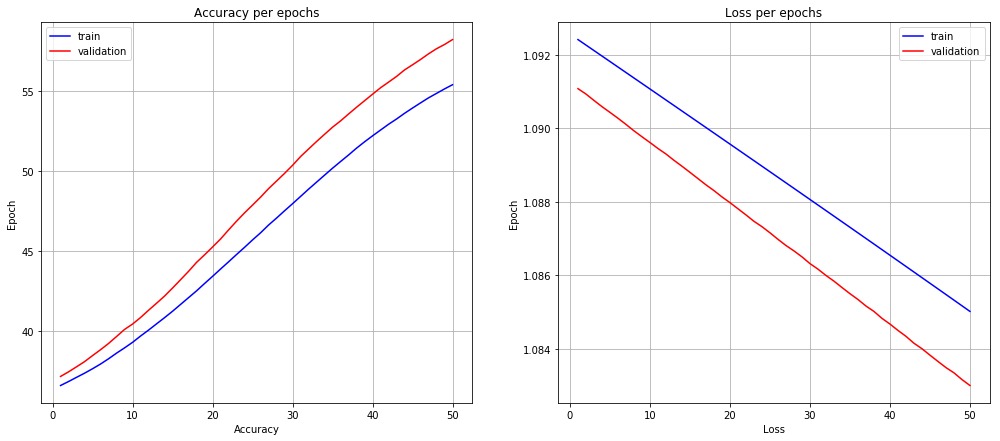

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs[0].grid()
axs[0].set_xlabel('Accuracy')
axs[0].set_ylabel('Epoch')
axs[0].set_title('Accuracy per epochs')

axs[1].grid()
axs[1].set_xlabel('Loss')
axs[1].set_ylabel('Epoch')
axs[1].set_title('Loss per epochs')

axs[0].plot(df_grp_epoch_train.index, df_grp_epoch_train['agg_acc'], label='train', color='blue')
axs[0].plot(df_grp_epoch_val.index, df_grp_epoch_val['agg_acc'], label='validation', color='red')
axs[0].legend()

axs[1].plot(df_grp_epoch_train.index, df_grp_epoch_train['agg_loss'], label='train', color='blue')
axs[1].plot(df_grp_epoch_val.index, df_grp_epoch_val['agg_loss'], label='validation', color='red')
axs[1].legend()

plt.savefig('results_dnn.png')

In [40]:
df_inf_train = pd.read_csv('models/DNN_39_128_512_128_6/inform_DNN_sgd_50.train.log')
df_inf_val = pd.read_csv('models/DNN_39_128_512_128_6/inform_DNN_sgd_50.val.log')
df_inf_train.sample(5)

,epoch,num_batch,loss,accuracy,agg_loss,agg_acc,lr,time_on_batch
55885,11.0,2756.0,1.951389,41.015625,1.941119,42.318748,0.000008,0.002627
17314,4.0,1376.0,1.960086,40.625000,2.002559,36.024936,0.000008,0.003259
29719,6.0,3155.0,1.931262,43.359375,1.967416,40.172717,0.000008,0.002376
22761,5.0,1510.0,2.010877,34.765625,1.982950,38.327815,0.000008,0.015568
9156,2.0,3844.0,2.036567,34.765625,2.098831,27.981209,0.000008,0.024405


In [41]:
df_grp_epoch_train = df_inf_train.groupby('epoch').last()
df_grp_epoch_val = df_inf_val.groupby('epoch').last()

df_grp_epoch_train.shape, df_grp_epoch_val.shape

((20, 7), (20, 7))

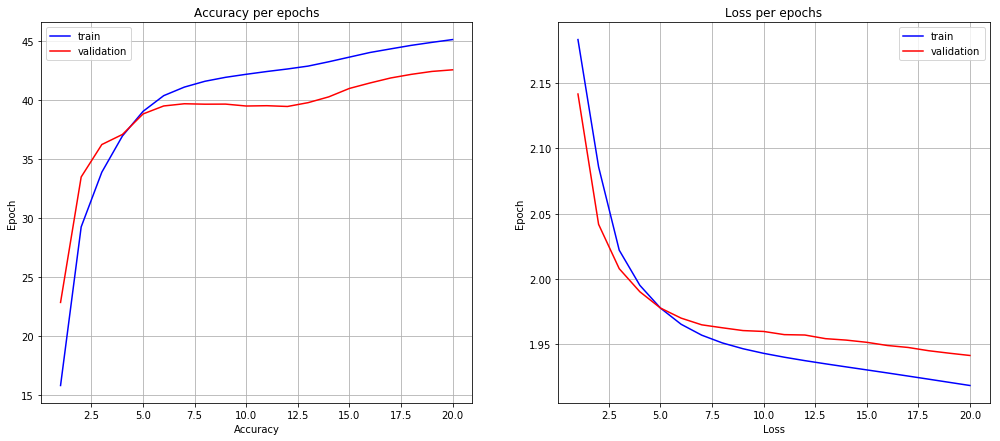

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs[0].grid()
axs[0].set_xlabel('Accuracy')
axs[0].set_ylabel('Epoch')
axs[0].set_title('Accuracy per epochs')

axs[1].grid()
axs[1].set_xlabel('Loss')
axs[1].set_ylabel('Epoch')
axs[1].set_title('Loss per epochs')

axs[0].plot(df_grp_epoch_train.index, df_grp_epoch_train['agg_acc'], label='train', color='blue')
axs[0].plot(df_grp_epoch_val.index, df_grp_epoch_val['agg_acc'], label='validation', color='red')
axs[0].legend()

axs[1].plot(df_grp_epoch_train.index, df_grp_epoch_train['agg_loss'], label='train', color='blue')
axs[1].plot(df_grp_epoch_val.index, df_grp_epoch_val['agg_loss'], label='validation', color='red')
axs[1].legend()

plt.savefig('results_cnn.png')